# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg

## Data Preprocessing

In [74]:
data = pd.read_excel('E:\GitHub\sherlock-final-project\pooled_data.xlsx', sheet_name="data")
data = data.iloc[:, 1:4]
data_ar = np.array(data)

## ACF-PACF

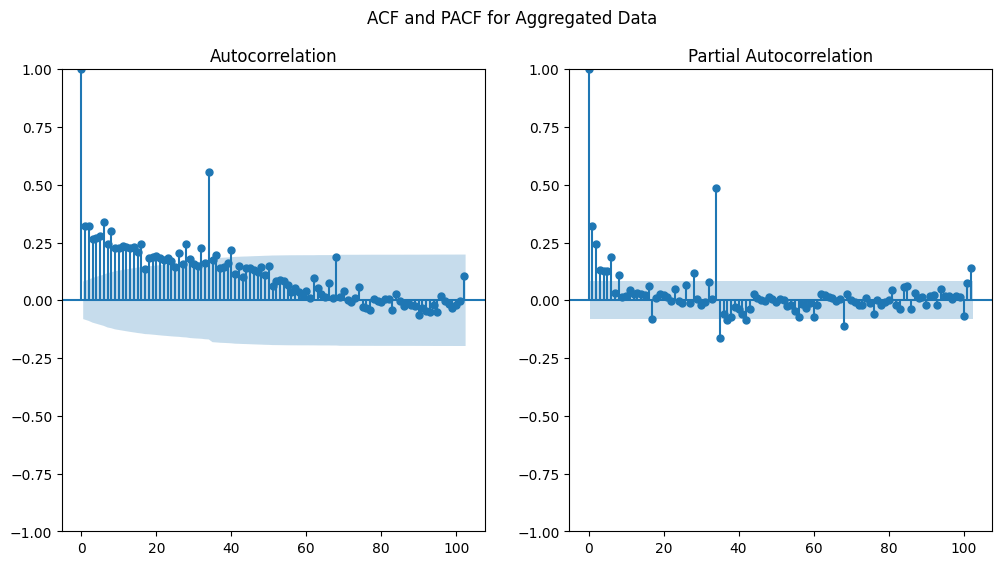

Suggested common N_PAST: 102


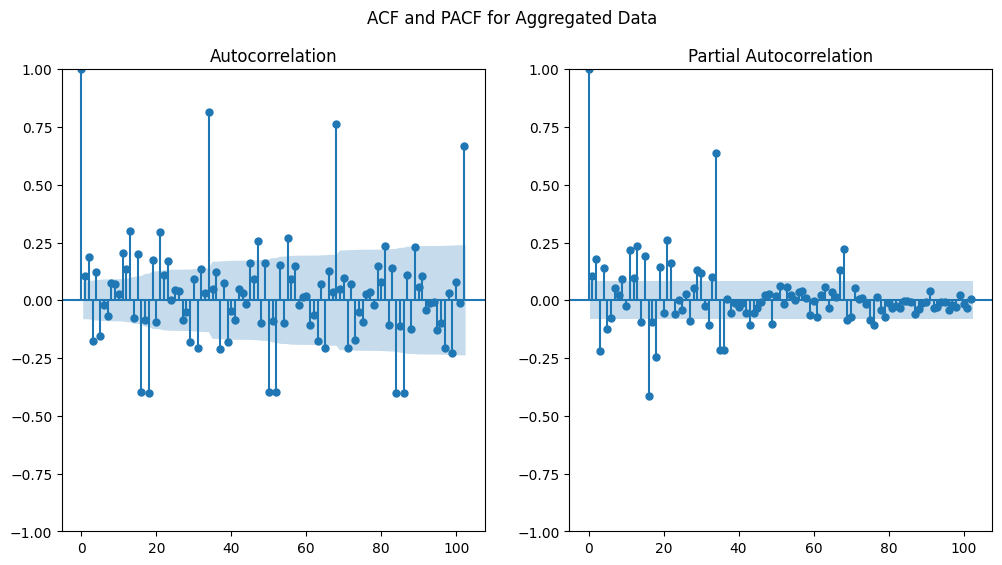

Suggested common N_PAST: 101


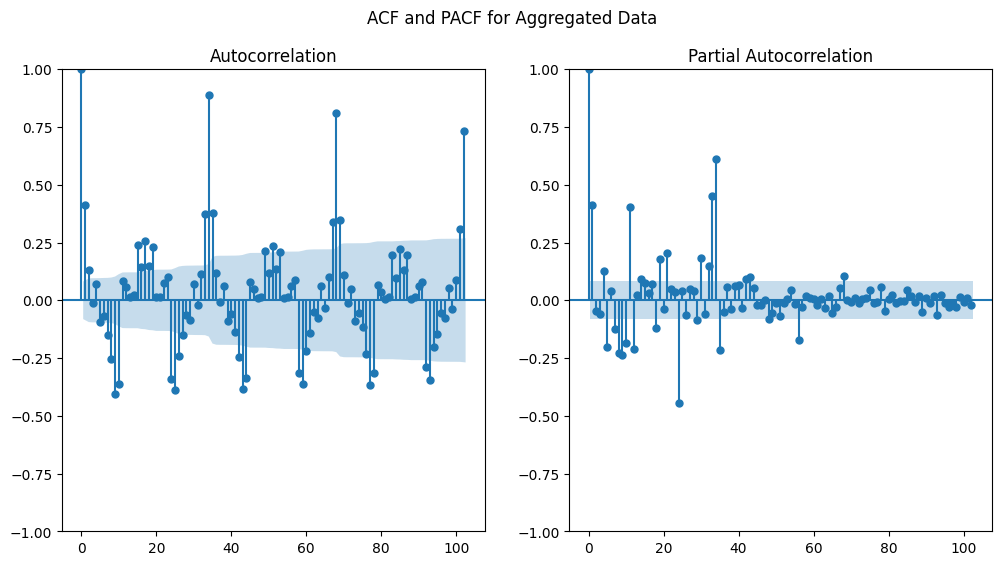

Suggested common N_PAST: 102


In [81]:
# Plot ACF and PACF for the aggregated data
def plot_acf_pacf(series, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=102)
    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=68)
    plt.show()

# Function to determine significant lags based on PACF
def significant_pacf_lags(series, threshold=0.2):
    pacf_values = pacf(series, nlags=102)
    significant_lags = np.where(np.abs(pacf_values) > threshold)[0]
    return significant_lags[significant_lags != 0]

def x_lag(aggregated_series):
    plot_acf_pacf(aggregated_series, "ACF and PACF for Aggregated Data")
    # Calculate significant lags for the aggregated data
    significant_lags = significant_pacf_lags(aggregated_series)
    # Determine a common N_PAST
    common_n_past = max(significant_lags) if len(significant_lags) > 0 else 1

    print("Suggested common N_PAST:", common_n_past)

x_lag(data['x1'])
x_lag(data['x2'])
x_lag(data['x3'])

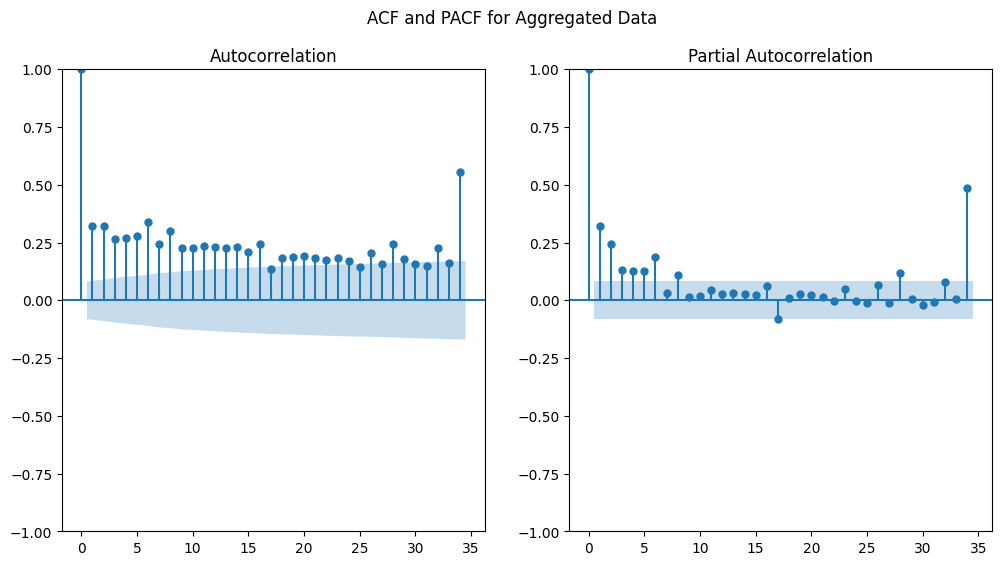

Suggested common N_PAST (iterations): 1
Actual N_PAST (data points): 34


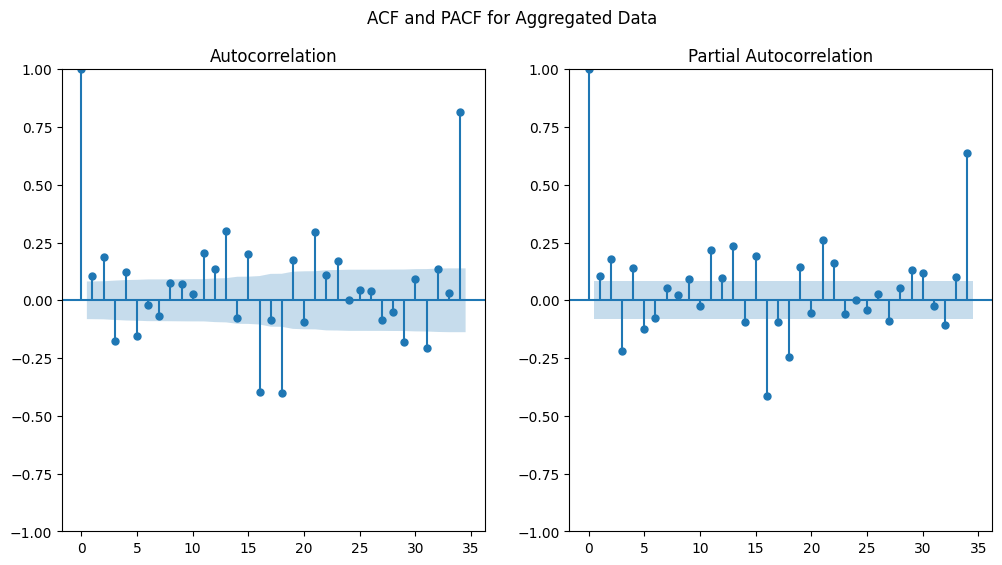

Suggested common N_PAST (iterations): 1
Actual N_PAST (data points): 34


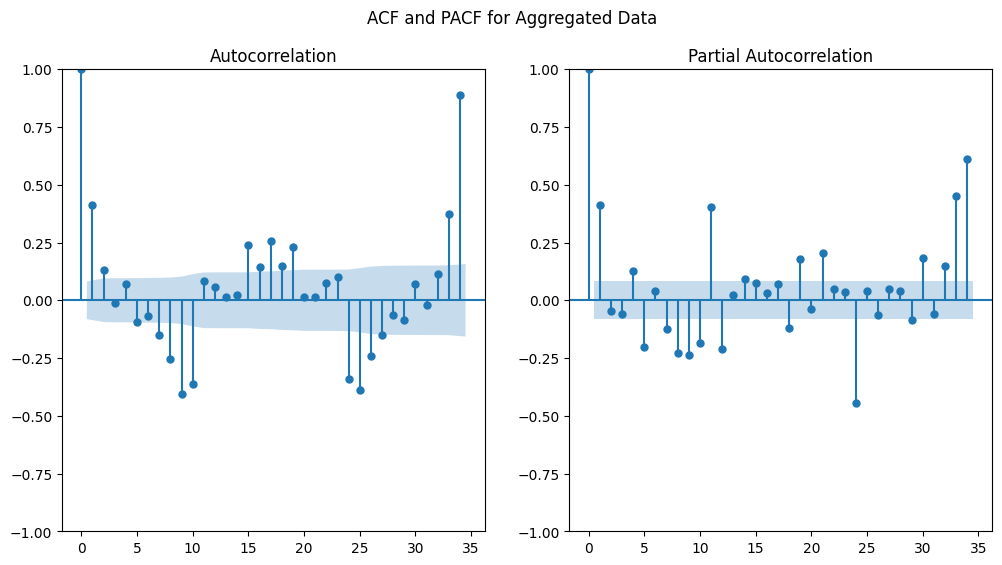

Suggested common N_PAST (iterations): 1
Actual N_PAST (data points): 34


In [110]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, adfuller

# Plot ACF and PACF for the aggregated data
def plot_acf_pacf(series, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=34)
    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=34)
    plt.show()

# Function to determine significant lags based on PACF
def significant_pacf_lags(series, threshold=0.2):
    pacf_values = pacf(series, nlags=34)
    significant_lags = np.where(np.abs(pacf_values) > threshold)[0]
    return significant_lags[significant_lags != 0]

# Function to check for stationarity
def check_stationarity(series, alpha=0.05):
    result = adfuller(series)
    p_value = result[1]
    return p_value < alpha  # If True, the series is stationary

# Function to make the series stationary
def make_stationary(series):
    differenced_series = series.diff().dropna()
    return differenced_series

# Function to determine the best N_PAST
def determine_best_n_past(aggregated_series, seasonal_period=34):
    # Check if the series is stationary
    if not check_stationarity(aggregated_series):
        print("Series is not stationary. Applying differencing...")
        aggregated_series = make_stationary(aggregated_series)
    
    plot_acf_pacf(aggregated_series, "ACF and PACF for Aggregated Data")
    
    # Calculate significant lags for the aggregated data
    significant_lags = significant_pacf_lags(aggregated_series)
    # Determine a common N_PAST
    max_significant_lag = max(significant_lags) if len(significant_lags) > 0 else 1
    # Adjust N_PAST to be a multiple of the seasonal period
    common_n_past = ((max_significant_lag + seasonal_period - 1) // seasonal_period) * seasonal_period

    print("Suggested common N_PAST (iterations):", common_n_past // seasonal_period)
    print("Actual N_PAST (data points):", common_n_past)

determine_best_n_past(data['x1'])
determine_best_n_past(data['x2'])
determine_best_n_past(data['x3'])

## 5. Terasvirta Linearity Test
#### Done in R language, check at terasvirtatest.R

## 6. Standarization

In [90]:
from sklearn.preprocessing import MinMaxScaler

def standardize_data(data):
    scaler = MinMaxScaler(feature_range=(-1,1))
    data_norm = scaler.fit_transform(data)
    return data_norm, scaler

x1_norm, x1_scaler = standardize_data(data_ar[:,0].reshape(-1,1))
x2_norm, x2_scaler = standardize_data(data_ar[:,1].reshape(-1,1))
x3_norm, x3_scaler = standardize_data(data_ar[:,2].reshape(-1,1))

## 7. Data Splitting

In [91]:
def windowed_dataset(series, batch_size, n_past, n_future, shift):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [92]:
BATCH_SIZE = 1
N_FUTURE = 1
SHIFT = 1
SPLIT_TIME = 442

In [93]:
x1_train = x1_norm[:SPLIT_TIME,]
x1_test = x1_norm[SPLIT_TIME:,]
x2_train = x2_norm[:SPLIT_TIME,]
x2_test = x2_norm[SPLIT_TIME:,]
x3_train = x3_norm[:SPLIT_TIME,]
x3_test = x3_norm[SPLIT_TIME:,]

train_set1 = windowed_dataset(series=x1_train, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)
test_set1 = windowed_dataset(series=x1_test, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)

train_set2 = windowed_dataset(series=x2_train, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)
test_set2 = windowed_dataset(series=x2_test, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)

train_set3 = windowed_dataset(series=x3_train, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)
test_set3 = windowed_dataset(series=x3_test, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)

## 8. Neural Network Architecture and Modelling

In [94]:
def mape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true = tf.maximum(y_true, epsilon)
    
    # Calculate MAPE
    mape = tf.reduce_mean(tf.abs((y_true - y_pred) / y_true))
    return mape

In [95]:
def modelling(train_dataset, test_dataset, epoch, loss_function, metrics, optimizer, activation, hidden_node):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(34,)),
                tf.keras.layers.Dense(hidden_node, activation=activation),
                tf.keras.layers.Dense(1)
                ])
        model.compile(loss=loss_function, optimizer=optimizer, metrics=[metrics])
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset)
        if __name__ == '__main__':
                model.save(f"model_{hidden_node}.h5")
        final_loss = history.history['loss'][-1]
        weights = model.get_weights()
        return final_loss, weights[0], weights[1], weights[2], weights[3]

In [111]:
model_sum = pd.DataFrame(columns=['mse', 'hl_weights', 'hl_bias', 'ol_weights', 'ol_bias'])
for n in range(1, 21):
    a,b,c,d,e = modelling(train_dataset=train_set3, 
                            test_dataset=test_set3,
                            epoch=50, 
                            loss_function='mse',
                            metrics = 'mae', 
                            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                            activation='relu',
                            hidden_node=n)
    model_sum.loc[n] = [a,b,c,d,e]                

Epoch 1/50
408/408 [==============================] - 1s 2ms/step - loss: 0.3103 - mae: 0.4280 - val_loss: 0.1880 - val_mae: 0.3699
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.1288 - mae: 0.2969 - val_loss: 0.1664 - val_mae: 0.3290
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.1069 - mae: 0.2678 - val_loss: 0.1590 - val_mae: 0.3165
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.1033 - mae: 0.2590 - val_loss: 0.1564 - val_mae: 0.3130
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.1018 - mae: 0.2550 - val_loss: 0.1534 - val_mae: 0.3080
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.1007 - mae: 0.2515 - val_loss: 0.1516 - val_mae: 0.3027
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.1002 - mae: 0.2506 - val_loss: 0.1508 - val_mae: 0.2992
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 3ms/step - loss: 0.1001 - mae: 0.2550 - val_loss: 0.1066 - val_mae: 0.2503
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0642 - mae: 0.1868 - val_loss: 0.0683 - val_mae: 0.1959
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0415 - mae: 0.1463 - val_loss: 0.0428 - val_mae: 0.1601
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0284 - mae: 0.1236 - val_loss: 0.0309 - val_mae: 0.1413
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0215 - mae: 0.1089 - val_loss: 0.0244 - val_mae: 0.1256
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0178 - mae: 0.1001 - val_loss: 0.0209 - val_mae: 0.1169
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0153 - mae: 0.0933 - val_loss: 0.0186 - val_mae: 0.1116
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0138 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1207 - mae: 0.2819 - val_loss: 0.1312 - val_mae: 0.2876
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0719 - mae: 0.2153 - val_loss: 0.0978 - val_mae: 0.2466
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0538 - mae: 0.1774 - val_loss: 0.0810 - val_mae: 0.2251
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0435 - mae: 0.1558 - val_loss: 0.0592 - val_mae: 0.1920
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0335 - mae: 0.1337 - val_loss: 0.0444 - val_mae: 0.1602
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0273 - mae: 0.1183 - val_loss: 0.0398 - val_mae: 0.1479
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0231 - mae: 0.1083 - val_loss: 0.0353 - val_mae: 0.1391
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0199 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1247 - mae: 0.2713 - val_loss: 0.1289 - val_mae: 0.2631
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0597 - mae: 0.1799 - val_loss: 0.0748 - val_mae: 0.1955
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0326 - mae: 0.1297 - val_loss: 0.0468 - val_mae: 0.1576
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0212 - mae: 0.1064 - val_loss: 0.0348 - val_mae: 0.1407
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0156 - mae: 0.0939 - val_loss: 0.0284 - val_mae: 0.1330
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0125 - mae: 0.0853 - val_loss: 0.0252 - val_mae: 0.1284
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0110 - mae: 0.0789 - val_loss: 0.0233 - val_mae: 0.1240
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0103 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1639 - mae: 0.3234 - val_loss: 0.1547 - val_mae: 0.3106
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0594 - mae: 0.1946 - val_loss: 0.0900 - val_mae: 0.2258
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0360 - mae: 0.1481 - val_loss: 0.0587 - val_mae: 0.1836
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0235 - mae: 0.1182 - val_loss: 0.0415 - val_mae: 0.1595
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0167 - mae: 0.0999 - val_loss: 0.0343 - val_mae: 0.1449
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0133 - mae: 0.0890 - val_loss: 0.0295 - val_mae: 0.1331
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0119 - mae: 0.0835 - val_loss: 0.0265 - val_mae: 0.1260
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0112 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1320 - mae: 0.2776 - val_loss: 0.1479 - val_mae: 0.2906
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0551 - mae: 0.1805 - val_loss: 0.0645 - val_mae: 0.1996
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0290 - mae: 0.1306 - val_loss: 0.0396 - val_mae: 0.1572
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0203 - mae: 0.1070 - val_loss: 0.0299 - val_mae: 0.1337
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0167 - mae: 0.0953 - val_loss: 0.0268 - val_mae: 0.1236
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0143 - mae: 0.0869 - val_loss: 0.0247 - val_mae: 0.1198
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0127 - mae: 0.0809 - val_loss: 0.0244 - val_mae: 0.1181
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0119 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1367 - mae: 0.2871 - val_loss: 0.0837 - val_mae: 0.2166
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0510 - mae: 0.1671 - val_loss: 0.0359 - val_mae: 0.1407
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0258 - mae: 0.1218 - val_loss: 0.0208 - val_mae: 0.1145
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0164 - mae: 0.0959 - val_loss: 0.0179 - val_mae: 0.1078
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0131 - mae: 0.0851 - val_loss: 0.0174 - val_mae: 0.1070
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0119 - mae: 0.0808 - val_loss: 0.0170 - val_mae: 0.1066
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0111 - mae: 0.0781 - val_loss: 0.0166 - val_mae: 0.1057
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0105 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 3ms/step - loss: 0.0734 - mae: 0.2145 - val_loss: 0.0716 - val_mae: 0.2009
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0277 - mae: 0.1299 - val_loss: 0.0380 - val_mae: 0.1525
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0169 - mae: 0.1010 - val_loss: 0.0269 - val_mae: 0.1298
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0137 - mae: 0.0896 - val_loss: 0.0224 - val_mae: 0.1193
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0125 - mae: 0.0842 - val_loss: 0.0204 - val_mae: 0.1140
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0116 - mae: 0.0808 - val_loss: 0.0193 - val_mae: 0.1098
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0109 - mae: 0.0781 - val_loss: 0.0182 - val_mae: 0.1060
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0103 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1810 - mae: 0.3157 - val_loss: 0.1083 - val_mae: 0.2465
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0449 - mae: 0.1543 - val_loss: 0.0590 - val_mae: 0.1769
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0271 - mae: 0.1206 - val_loss: 0.0451 - val_mae: 0.1569
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1054 - val_loss: 0.0348 - val_mae: 0.1405
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0161 - mae: 0.0944 - val_loss: 0.0279 - val_mae: 0.1280
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0139 - mae: 0.0875 - val_loss: 0.0238 - val_mae: 0.1188
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0124 - mae: 0.0827 - val_loss: 0.0217 - val_mae: 0.1142
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0113 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1179 - mae: 0.2574 - val_loss: 0.0642 - val_mae: 0.1956
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0320 - mae: 0.1339 - val_loss: 0.0385 - val_mae: 0.1537
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0188 - mae: 0.1031 - val_loss: 0.0290 - val_mae: 0.1359
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0138 - mae: 0.0877 - val_loss: 0.0249 - val_mae: 0.1260
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0119 - mae: 0.0800 - val_loss: 0.0228 - val_mae: 0.1199
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0109 - mae: 0.0758 - val_loss: 0.0215 - val_mae: 0.1158
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0102 - mae: 0.0734 - val_loss: 0.0207 - val_mae: 0.1133
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0096 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.0638 - mae: 0.1911 - val_loss: 0.0393 - val_mae: 0.1631
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0207 - mae: 0.1111 - val_loss: 0.0276 - val_mae: 0.1314
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0157 - mae: 0.0948 - val_loss: 0.0245 - val_mae: 0.1231
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0137 - mae: 0.0875 - val_loss: 0.0226 - val_mae: 0.1174
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0123 - mae: 0.0833 - val_loss: 0.0208 - val_mae: 0.1122
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0113 - mae: 0.0795 - val_loss: 0.0191 - val_mae: 0.1074
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0105 - mae: 0.0765 - val_loss: 0.0182 - val_mae: 0.1046
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0100 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.0844 - mae: 0.2142 - val_loss: 0.0646 - val_mae: 0.2022
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0245 - mae: 0.1195 - val_loss: 0.0351 - val_mae: 0.1474
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0160 - mae: 0.0944 - val_loss: 0.0288 - val_mae: 0.1315
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0141 - mae: 0.0876 - val_loss: 0.0273 - val_mae: 0.1279
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0130 - mae: 0.0838 - val_loss: 0.0264 - val_mae: 0.1258
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0121 - mae: 0.0807 - val_loss: 0.0253 - val_mae: 0.1231
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0114 - mae: 0.0782 - val_loss: 0.0245 - val_mae: 0.1212
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0106 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1358 - mae: 0.2858 - val_loss: 0.0646 - val_mae: 0.2160
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0268 - mae: 0.1237 - val_loss: 0.0272 - val_mae: 0.1280
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0156 - mae: 0.0928 - val_loss: 0.0190 - val_mae: 0.1060
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0125 - mae: 0.0817 - val_loss: 0.0163 - val_mae: 0.0978
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0110 - mae: 0.0772 - val_loss: 0.0154 - val_mae: 0.0952
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0101 - mae: 0.0740 - val_loss: 0.0151 - val_mae: 0.0953
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0095 - mae: 0.0717 - val_loss: 0.0152 - val_mae: 0.0957
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0090 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.0684 - mae: 0.2027 - val_loss: 0.0437 - val_mae: 0.1631
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0182 - mae: 0.1034 - val_loss: 0.0257 - val_mae: 0.1243
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0122 - mae: 0.0842 - val_loss: 0.0205 - val_mae: 0.1113
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0105 - mae: 0.0765 - val_loss: 0.0187 - val_mae: 0.1069
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0097 - mae: 0.0724 - val_loss: 0.0178 - val_mae: 0.1042
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0092 - mae: 0.0703 - val_loss: 0.0174 - val_mae: 0.1026
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0088 - mae: 0.0685 - val_loss: 0.0172 - val_mae: 0.1021
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0084 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.0979 - mae: 0.2370 - val_loss: 0.0530 - val_mae: 0.1798
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1052 - val_loss: 0.0242 - val_mae: 0.1253
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0126 - mae: 0.0835 - val_loss: 0.0193 - val_mae: 0.1107
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0103 - mae: 0.0753 - val_loss: 0.0178 - val_mae: 0.1060
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0093 - mae: 0.0713 - val_loss: 0.0171 - val_mae: 0.1036
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0085 - mae: 0.0687 - val_loss: 0.0167 - val_mae: 0.1017
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0080 - mae: 0.0664 - val_loss: 0.0163 - val_mae: 0.1004
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0076 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1131 - mae: 0.2313 - val_loss: 0.0475 - val_mae: 0.1591
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0221 - mae: 0.1088 - val_loss: 0.0184 - val_mae: 0.1050
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0130 - mae: 0.0843 - val_loss: 0.0146 - val_mae: 0.0970
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0112 - mae: 0.0767 - val_loss: 0.0139 - val_mae: 0.0956
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0103 - mae: 0.0730 - val_loss: 0.0136 - val_mae: 0.0955
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0096 - mae: 0.0701 - val_loss: 0.0134 - val_mae: 0.0957
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0091 - mae: 0.0679 - val_loss: 0.0135 - val_mae: 0.0962
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0087 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 1s 2ms/step - loss: 0.1293 - mae: 0.2704 - val_loss: 0.0531 - val_mae: 0.1749
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0284 - mae: 0.1240 - val_loss: 0.0233 - val_mae: 0.1172
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0155 - mae: 0.0901 - val_loss: 0.0179 - val_mae: 0.1026
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0126 - mae: 0.0819 - val_loss: 0.0168 - val_mae: 0.0997
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0111 - mae: 0.0767 - val_loss: 0.0162 - val_mae: 0.0983
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0100 - mae: 0.0733 - val_loss: 0.0155 - val_mae: 0.0966
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0092 - mae: 0.0706 - val_loss: 0.0149 - val_mae: 0.0952
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0087 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 2s 3ms/step - loss: 0.1051 - mae: 0.2270 - val_loss: 0.0455 - val_mae: 0.1666
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0189 - mae: 0.0992 - val_loss: 0.0352 - val_mae: 0.1497
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0144 - mae: 0.0862 - val_loss: 0.0317 - val_mae: 0.1428
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0126 - mae: 0.0808 - val_loss: 0.0298 - val_mae: 0.1395
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0116 - mae: 0.0777 - val_loss: 0.0281 - val_mae: 0.1353
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0107 - mae: 0.0750 - val_loss: 0.0261 - val_mae: 0.1302
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0099 - mae: 0.0721 - val_loss: 0.0247 - val_mae: 0.1268
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0093 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 2s 3ms/step - loss: 0.0941 - mae: 0.2297 - val_loss: 0.0476 - val_mae: 0.1729
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0180 - mae: 0.1019 - val_loss: 0.0237 - val_mae: 0.1241
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0129 - mae: 0.0839 - val_loss: 0.0218 - val_mae: 0.1184
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0112 - mae: 0.0784 - val_loss: 0.0207 - val_mae: 0.1153
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0102 - mae: 0.0752 - val_loss: 0.0197 - val_mae: 0.1124
Epoch 6/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0095 - mae: 0.0727 - val_loss: 0.0190 - val_mae: 0.1105
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0089 - mae: 0.0706 - val_loss: 0.0185 - val_mae: 0.1087
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0085 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 2s 3ms/step - loss: 0.1263 - mae: 0.2593 - val_loss: 0.0469 - val_mae: 0.1576
Epoch 2/50
408/408 [==============================] - 1s 4ms/step - loss: 0.0194 - mae: 0.1028 - val_loss: 0.0160 - val_mae: 0.0997
Epoch 3/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0125 - mae: 0.0817 - val_loss: 0.0138 - val_mae: 0.0922
Epoch 4/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0109 - mae: 0.0761 - val_loss: 0.0137 - val_mae: 0.0918
Epoch 5/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0099 - mae: 0.0724 - val_loss: 0.0136 - val_mae: 0.0918
Epoch 6/50
408/408 [==============================] - 1s 3ms/step - loss: 0.0091 - mae: 0.0695 - val_loss: 0.0133 - val_mae: 0.0904
Epoch 7/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0085 - mae: 0.0674 - val_loss: 0.0133 - val_mae: 0.0907
Epoch 8/50
408/408 [==============================] - 1s 2ms/step - loss: 0.0081 - mae:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [112]:
model_sum.to_excel('model_train_sumary.xlsx')

## 9. Prediction

In [113]:
modelx1 = tf.keras.models.load_model('model_x1/model_18.h5')
modelx2 = tf.keras.models.load_model('model_x2/model_19.h5')
modelx3 = tf.keras.models.load_model('model_19.h5')

### X1 (Tingkat Pertumbuhan Ekonomi)

1/1 [==============================] - 0s 22ms/step
[ 0.01046839  0.01466731  0.0382847   0.12357122  0.21363714  0.07588769
  0.11645289 -0.03314025 -0.08923531 -0.01847082  0.08994679  0.08388987
  0.03771595 -0.03033199  0.06100027 -0.1604281   0.12650926  0.11577651
  0.03603027  0.03238007 -0.01965432  0.06126592  0.08591878  0.18195519
  0.1019496   0.16758905  0.00667293  0.00541038  0.08665414  0.25289124
  0.02954151  0.04429878  0.04676546 -0.01821448  0.01754512  0.07782605
  0.03088495  0.14780483  0.09421763  0.11337905  0.09706861  0.0283157
 -0.02986424  0.01005637  0.13323368  0.11624286 -0.00144389 -0.02954132
  0.03745125 -0.06009151  0.07796697  0.12593542  0.0233587   0.04823647
 -0.00877111 -0.00597623  0.06497711  0.15699206  0.09960678  0.09016331
  0.03054339 -0.01258928  0.04962624  0.25490317  0.07211876  0.05451439
  0.04505128 -0.02245434  0.03843197  0.11507356  0.07989617  0.1335748
  0.11324036  0.09696268  0.06724741  0.00308859  0.0055788   0.0545148
  

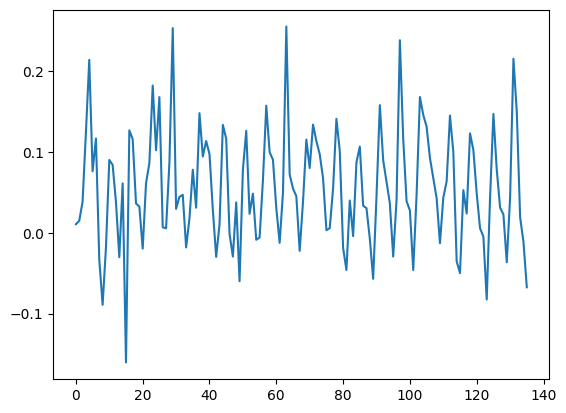

In [100]:
initial_input_data = x1_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx1.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x1predictions = np.array(predictions)

print(x1predictions)
plt.plot(x1predictions)

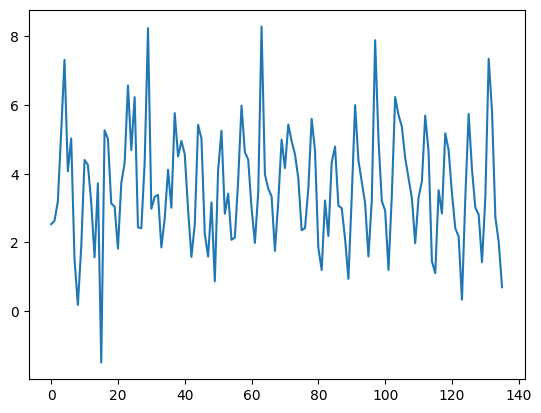

In [101]:
x1predictions = x1predictions.reshape(-1,1)
x1_pred = x1_scaler.inverse_transform(x1predictions).flatten()
plt.plot(x1_pred)

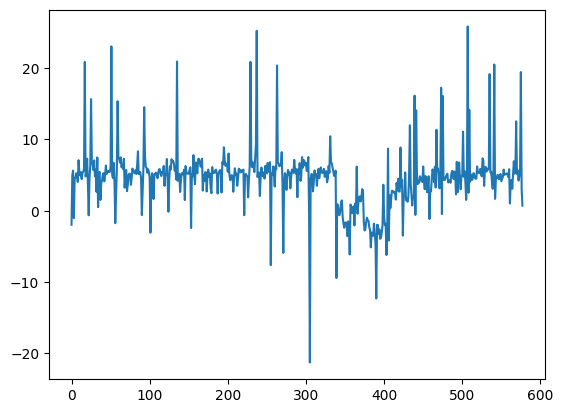

In [102]:
plt.plot(data['x1'])

### X2 (Tingkat Pengangguran Terbuka)

In [106]:
initial_input_data = x2_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx2.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x2predictions = np.array(predictions)

print(x2predictions)


1/1 [==============================] - 0s 25ms/step
[-0.02032805 -0.14619865 -0.04194937 -0.11600551 -0.30400318 -0.07050272
 -0.30066335 -0.2682066  -0.16641822  0.33136684  0.4016462   0.55381185
 -0.11986725 -0.41190243 -0.08716173  0.62916034 -0.5059995  -0.30881345
 -0.45861495 -0.0998207  -0.41017812 -0.21729578  0.11398344 -0.10182351
  0.2720616  -0.10824703 -0.00812363 -0.08712029 -0.3873362  -0.20138998
 -0.05675586 -0.30657202  0.03757377 -0.3816828   0.27608496  0.04772606
 -0.06923006 -0.07596209 -0.5036943  -0.45918536 -0.45496017 -0.5152459
 -0.12339024  0.10249022  0.13461706  0.27038485 -0.1011513  -0.54387105
 -0.21943231  0.08844677 -0.74899894 -0.39354318 -0.51831853  0.0760579
 -0.07883099 -0.06677252  0.4317711   0.20412649 -0.29136252  0.03191226
 -0.07233768 -0.10782877 -0.51218563 -0.12158622  0.13635054 -0.08568272
  0.16018775  0.43135822 -0.02414164 -0.3489378   0.04099549 -0.03895062
 -0.36513072 -0.74482983 -0.55783445 -0.28135657 -0.07804268  0.06847431
 

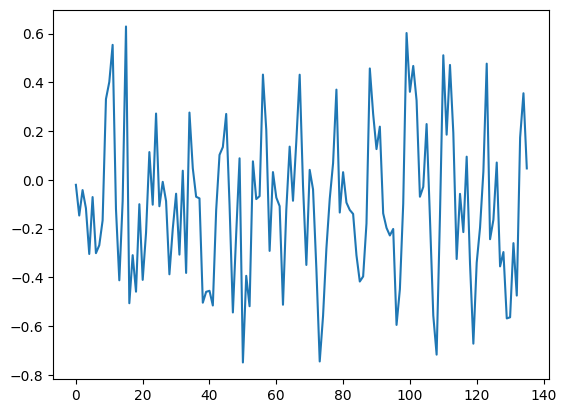

In [107]:
plt.plot(x2predictions)

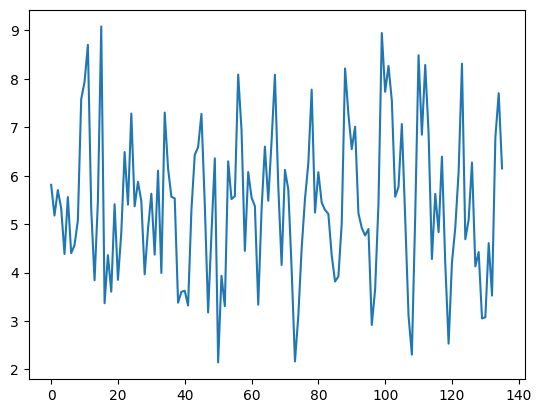

In [108]:
x2predictions = x2predictions.reshape(-1,1)
x2_pred = x2_scaler.inverse_transform(x2predictions).flatten()
plt.plot(x2_pred)

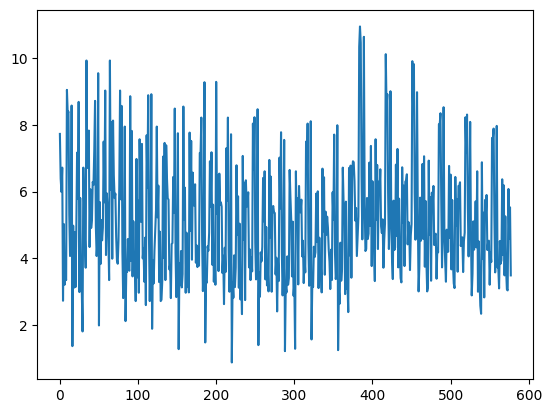

In [109]:
plt.plot(data['x2'])

### X3 (Rasio Gini)

In [114]:
initial_input_data = x3_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx3.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x3predictions = np.array(predictions)

print(x3predictions)

1/1 [==============================] - 0s 22ms/step
[-0.17418021 -0.4435832  -0.6533746  -0.0516614  -0.07595935 -0.07612238
 -0.19346267 -0.00226575 -0.5236314   0.01447483  0.62411046  0.7542771
  0.42021236  1.0240375   0.20997173  0.29970044  0.12476724  0.13070296
  0.06516074 -0.27396438 -0.16829436 -0.268434    0.0112259  -0.6379212
 -0.02374022 -0.23824687  0.22288717  0.4437716   0.4628783  -0.03959412
 -0.31141675 -0.1433172   0.2623944   0.29919893 -0.16984847 -0.5014399
 -0.45610532  0.03119913 -0.18647966 -0.41267323 -0.12264749  0.15729919
 -0.52198094  0.02545768  0.56684405  0.84080034  0.41783944  0.78718156
  0.07465883  0.3079597   0.04181725  0.06359158  0.23360027 -0.36706036
 -0.06659812 -0.1515502   0.04327339 -0.57380337 -0.10891705 -0.04910316
  0.21818663  0.5031705   0.28800213 -0.14619239 -0.26739225 -0.13068993
  0.215824    0.06421799 -0.18644978 -0.5366878  -0.19386213  0.08371026
 -0.3790323  -0.41446933  0.2322361   0.32565704 -0.3675432   0.04447297
  

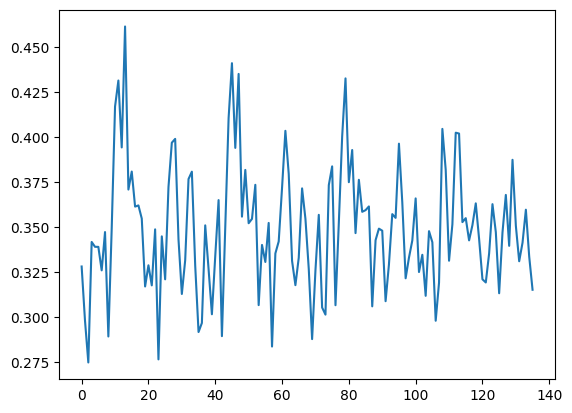

In [115]:
x3predictions = x3predictions.reshape(-1,1)
x3_pred = x3_scaler.inverse_transform(x3predictions).flatten()
plt.plot(x3_pred)

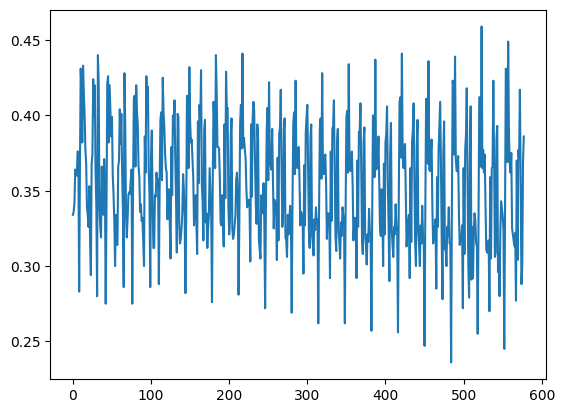

In [116]:
plt.plot(data['x3'])

## 10. Prediction Recap

In [119]:
model_pred = np.column_stack((x1_pred, x2_pred, x3_pred))
model_pred = pd.DataFrame(model_pred, columns=['x1', 'x2', 'x3'])
model_pred.to_excel('x_prediction.xlsx')